# Centroid-based clustering algorithms

Explore performance of centroid-based clustering algorithms. 

refs: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

### Boilerplate

In [11]:
import numpy as np
import awkward as ak

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture

from reco.event import remap_arrays_by_label, remap_items_by_label
from reco.plotting import plot_sim_reco, plot_tracksters, plot_dendrogram
from reco.energy import get_total_energy
from reco.data import get_bary_data, get_lc_data, get_event_data, clusters_by_indices

from reco.evaluation import evaluate, evaluate_remapped, baseline_evaluation, f_score

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_1.root"

ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [12]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

### Extract the event data

In [22]:
eid = 3

t_indexes = trackster_data["vertices_indexes"][eid]
t_multiplicity = trackster_data["vertices_multiplicity"][eid]

# simulation
st_indexes = simtrackster_data["stsSC_vertices_indexes"][eid]
st_multiplicity = simtrackster_data["stsSC_vertices_multiplicity"][eid]

t_x, t_y, t_z, t_energy = clusters_by_indices(cluster_data, t_indexes, eid)
st_x, st_y, st_z, st_energy = clusters_by_indices(cluster_data, st_indexes, eid)

nhits = cluster_data["cluster_number_of_hits"][eid]

### Input evaluation

Tracksters reco: 36, tracksters sim: 2
Simulated energy: 620.42 GeV, reconstructed energy: 489.88 GeV (78.96%)


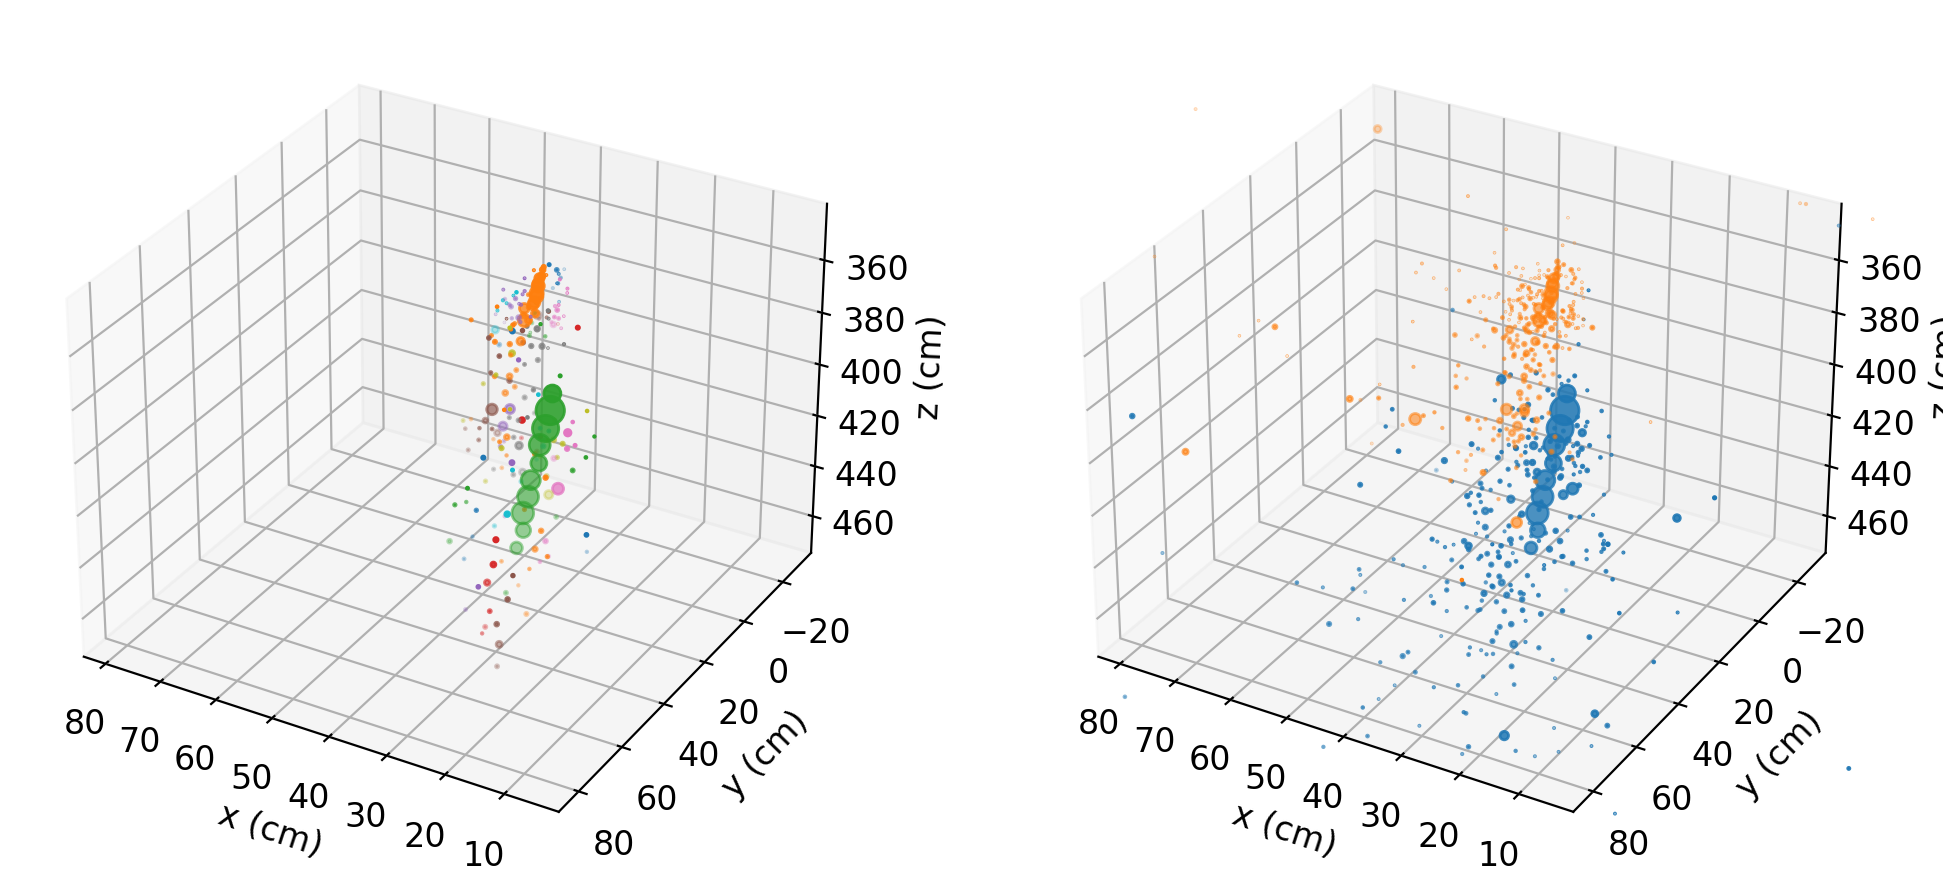

In [23]:
print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")

reco_total = get_total_energy(t_energy, t_multiplicity)
sim_total = get_total_energy(st_energy, st_multiplicity)
print(f"Simulated energy: {sim_total:.2f} GeV, reconstructed energy: {reco_total:.2f} GeV ({(reco_total / sim_total) * 100:.2f}%)")

ax1, ax2 = plot_sim_reco(
    t_x,
    t_y,
    t_z,
    t_energy,
    st_x,
    st_y,
    st_z,
    st_energy, 
    st_indexes,
    st_multiplicity,
)

In [5]:
precision, recall, fscore = evaluate(
    nhits,
    t_indexes,
    st_indexes,
    t_energy,
    st_energy,
    t_multiplicity,
    st_multiplicity
)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

Precision: 0.99, Recall: 0.15, F-score: 0.46


### k-means

Apply k-means algorithm on CLUE3D barycentres

In: 71 Out: 14 Precision: 0.95, Recall: 0.17, F-score: 0.49


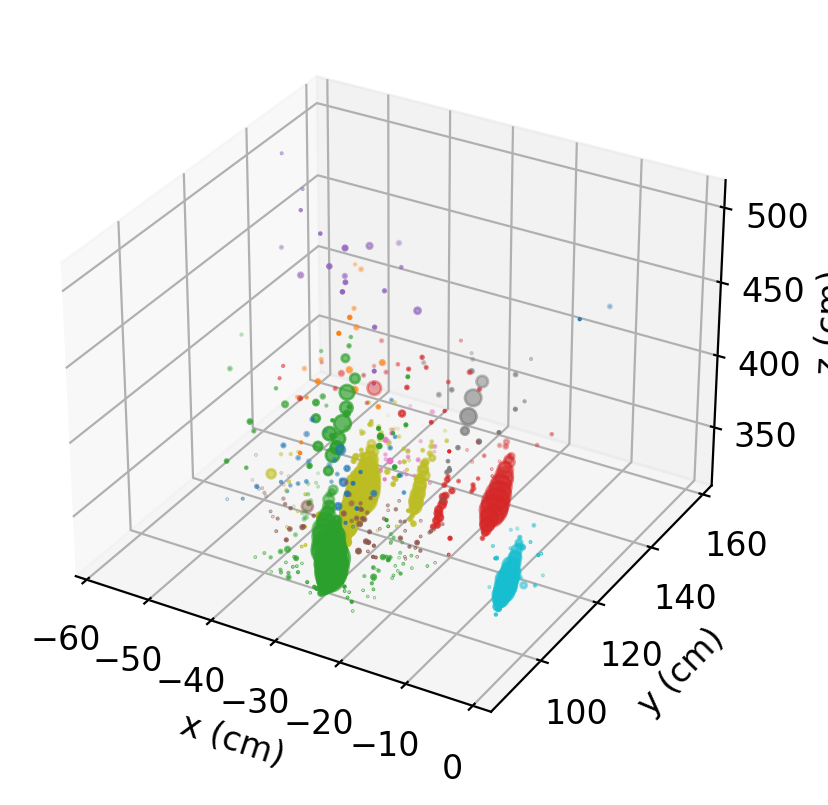

In [6]:
# kmeans on barycentres
def kmeans_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X_bary, sample_weight=raw_e)
    return kmeans.labels_

labels = kmeans_bary(trackster_data, eid)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

#### LC level clustering

Running clustering on layerclusters - for comparison

Precision: 0.88, Recall: 0.15, F-score: 0.44


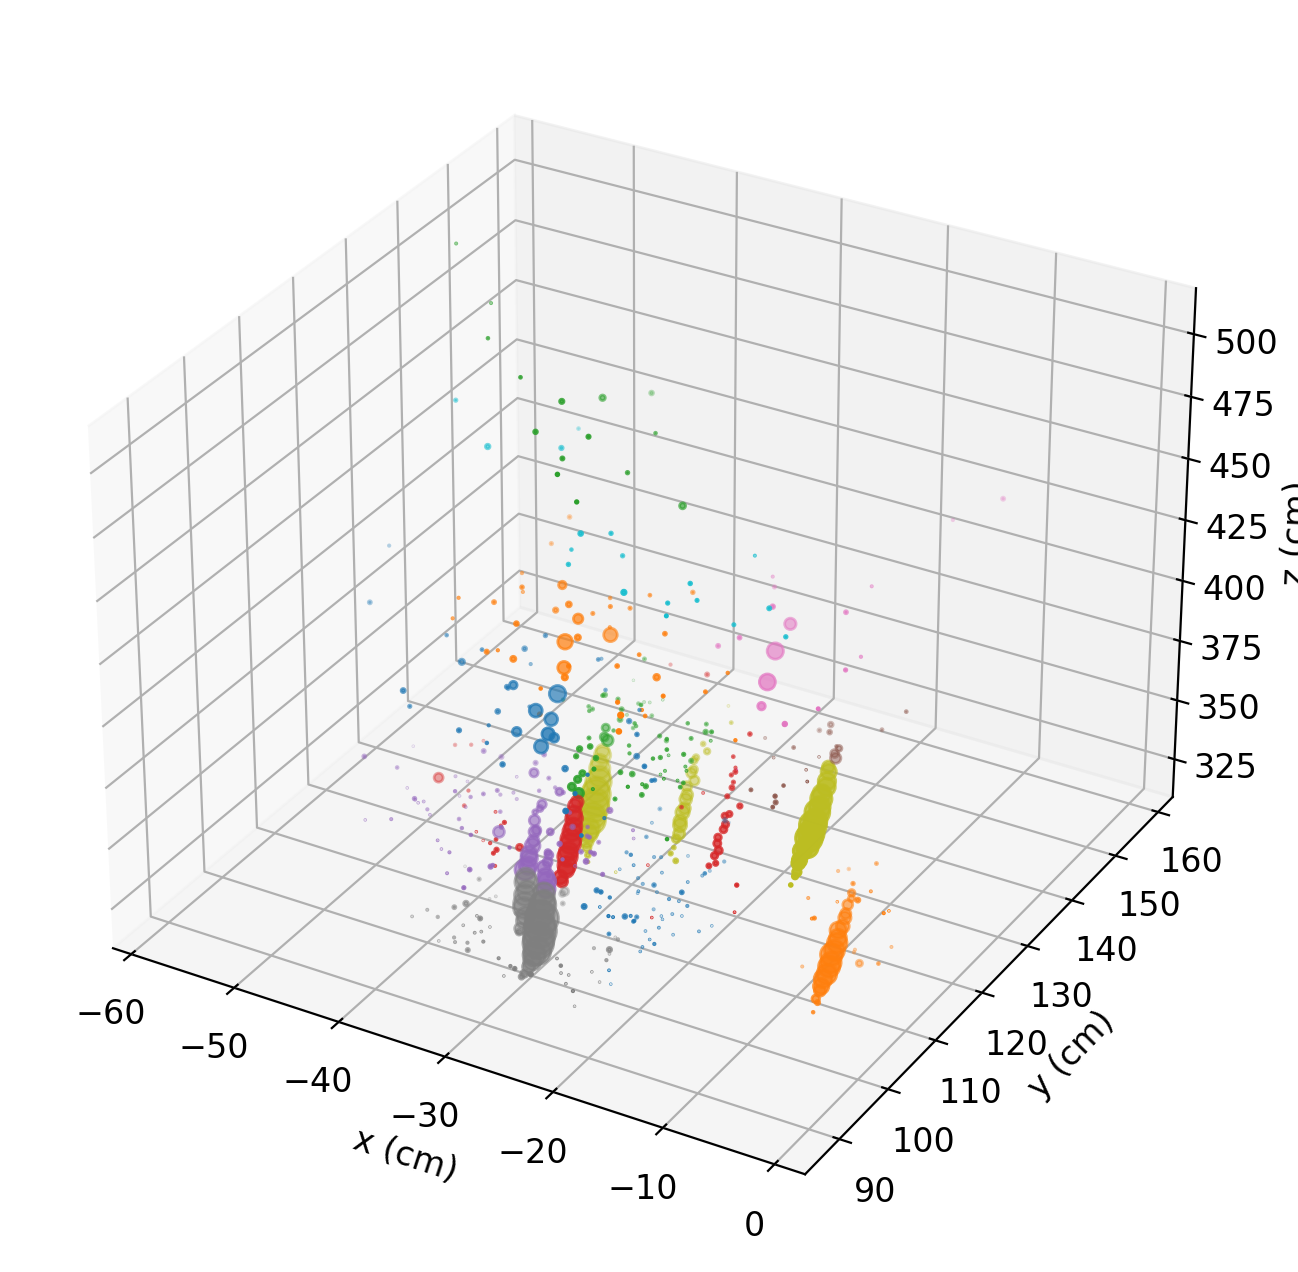

In [7]:
### Doesn really hehlp
K = sum(trackster_data["raw_energy"][eid] > 10)

X_vertices = get_lc_data(cluster_data, trackster_data, eid)
# kmeans = KMeans(n_clusters=K, random_state=0).fit(X_vertices)
# labels = kmeans.labels_
gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_vertices)
labels = gmm.predict(X_vertices)

ri = remap_items_by_label(ak.flatten(t_indexes), labels)
re = remap_items_by_label(ak.flatten(t_energy), labels)
rm = remap_items_by_label(ak.flatten(t_multiplicity), labels)

precision, recall, fscore = evaluate(nhits, ri, st_indexes, re, st_energy, rm, st_multiplicity)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

rx = remap_items_by_label(ak.flatten(t_x), labels)
ry = remap_items_by_label(ak.flatten(t_y), labels)
rz = remap_items_by_label(ak.flatten(t_z), labels)
re = remap_items_by_label(ak.flatten(t_energy), labels)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
plot_tracksters(ax, rx, ry, rz, re)
plt.show()

### GMM

Apply Gaussian Mixture Models on barycentres and layerclusters

In: 71 Out: 14 Precision: 0.92, Recall: 0.17, F-score: 0.49


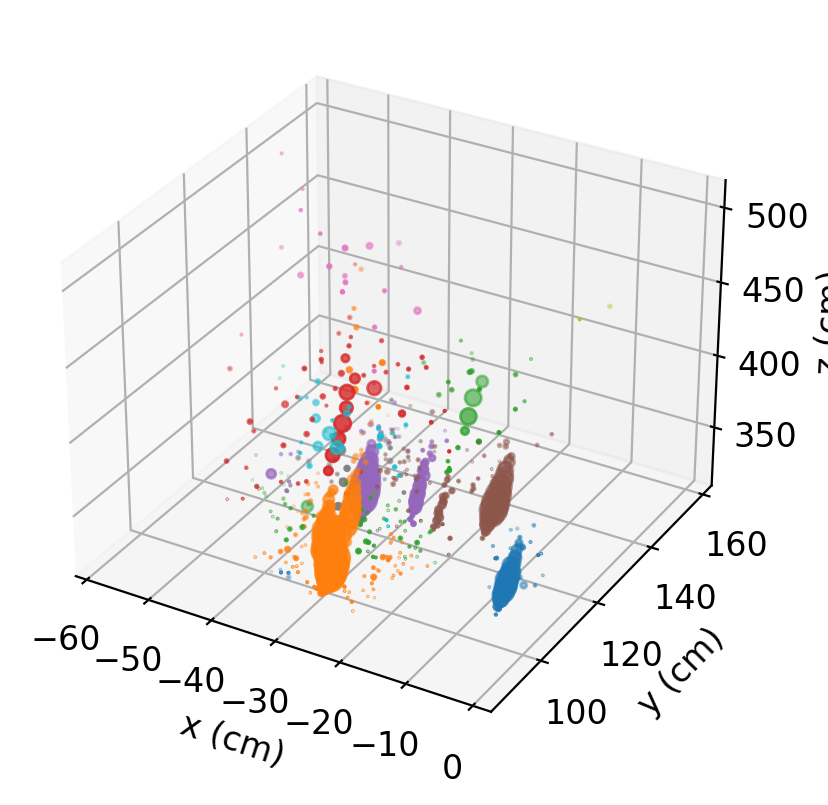

In [8]:
# kmeans on barycentres

def gmm_bary(_data, _eid, eng_t=10):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    K = sum(raw_e > eng_t)
    gmm = GaussianMixture(n_components=K, covariance_type='full').fit(X_bary)
    return gmm.predict(X_bary)

labels = gmm_bary(trackster_data, eid)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### DBSCAN

In: 71 Out: 8 Precision: 0.54, Recall: 0.24, F-score: 0.43


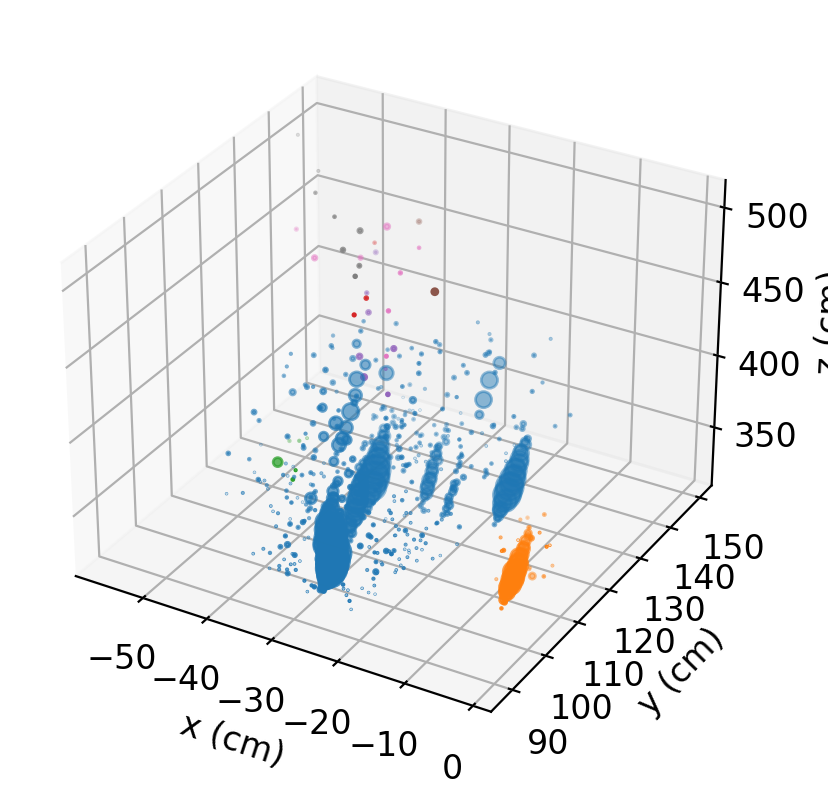

In [9]:
def dbscan_bary(_data, _eid, eps=2):
    X_bary = get_bary_data(_data, _eid)
    raw_e = _data["raw_energy"][_eid]
    dbscan = DBSCAN(eps=eps, min_samples=1).fit(X_bary, sample_weight=raw_e)
    return dbscan.labels_

labels = dbscan_bary(trackster_data, eid, eps=12)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### Meanshift

In: 36 Out: 8 Precision: 0.92, Recall: 0.55, F-score: 0.81


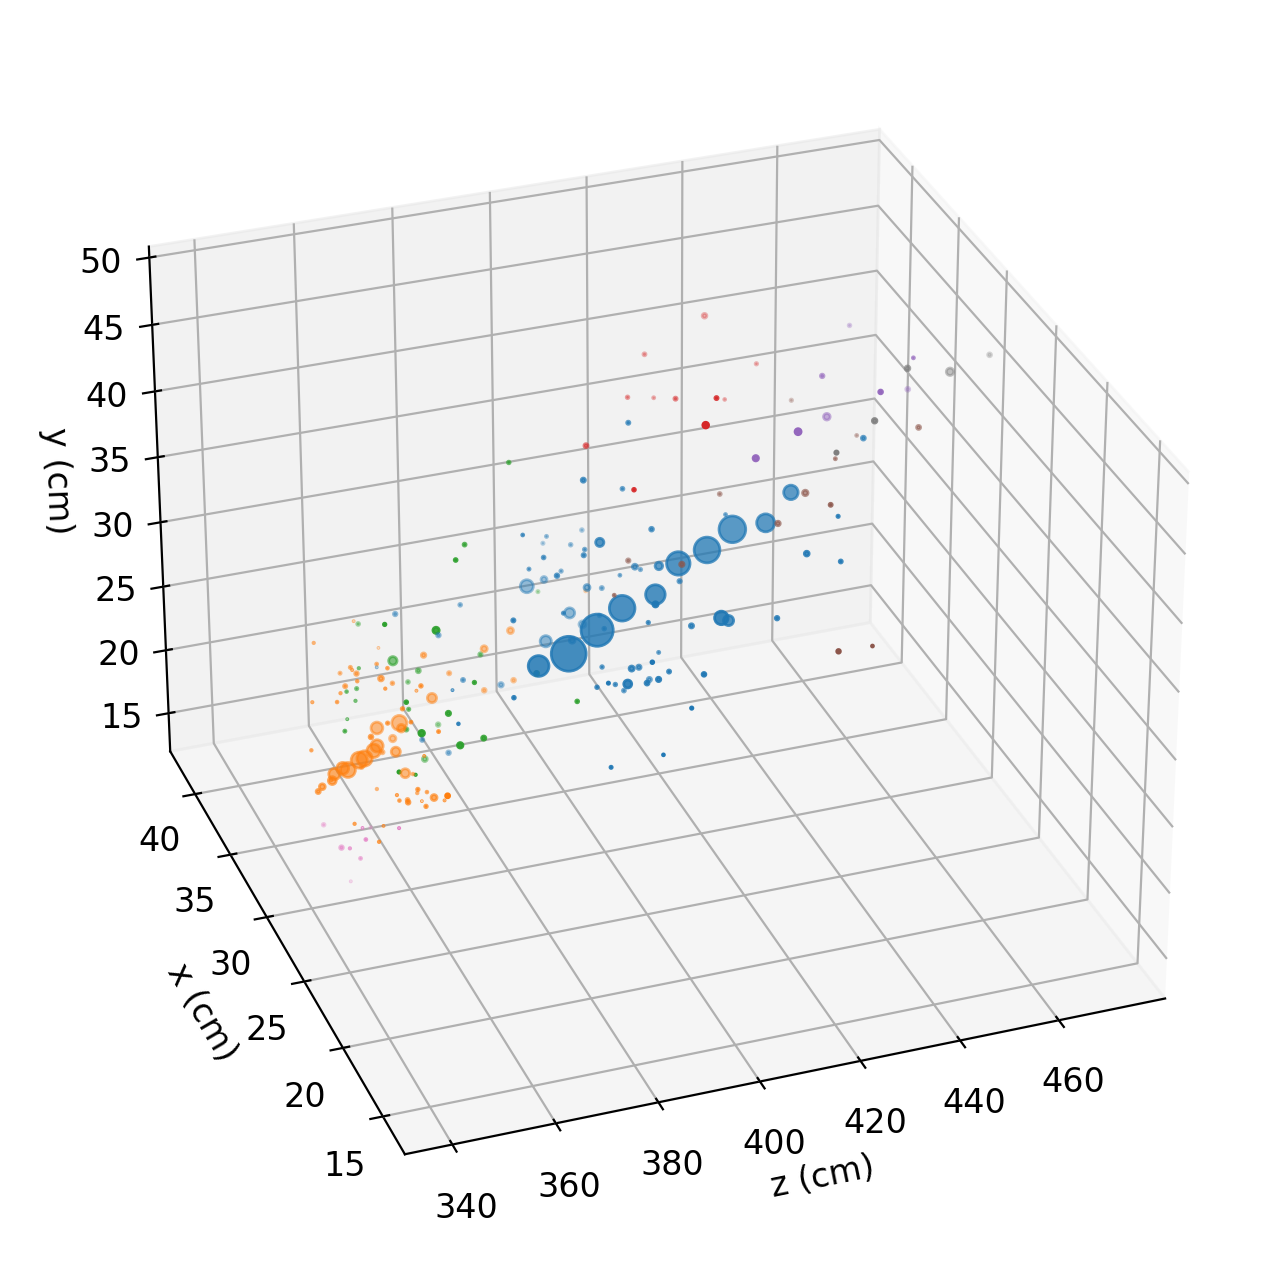

In [25]:
def meanshift_bary(_data, _eid, bandwidth=10):
    X_bary = get_bary_data(_data, _eid)
    ms = MeanShift(bandwidth=bandwidth).fit(X_bary)
    return ms.labels_

labels = meanshift_bary(trackster_data, eid, bandwidth=10)
r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection="3d")

ax.view_init(elev=30, azim=-110)

ax.set_xlabel("z (cm)")
ax.set_ylabel("x (cm)")
ax.set_zlabel("y (cm)")

for i, x, y, z, e in zip(range(len(r_x)), r_z, r_x, r_y, r_e):
    ax.scatter(x, y, z, s=np.array(e)*3)

fig.savefig('export/meanshift-two-pion.pdf', dpi=300, bbox_inches='tight', transparent=True)


precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

### Agglomerative

In: 15 Out: 7 Precision: 1.00, Recall: 0.21, F-score: 0.88


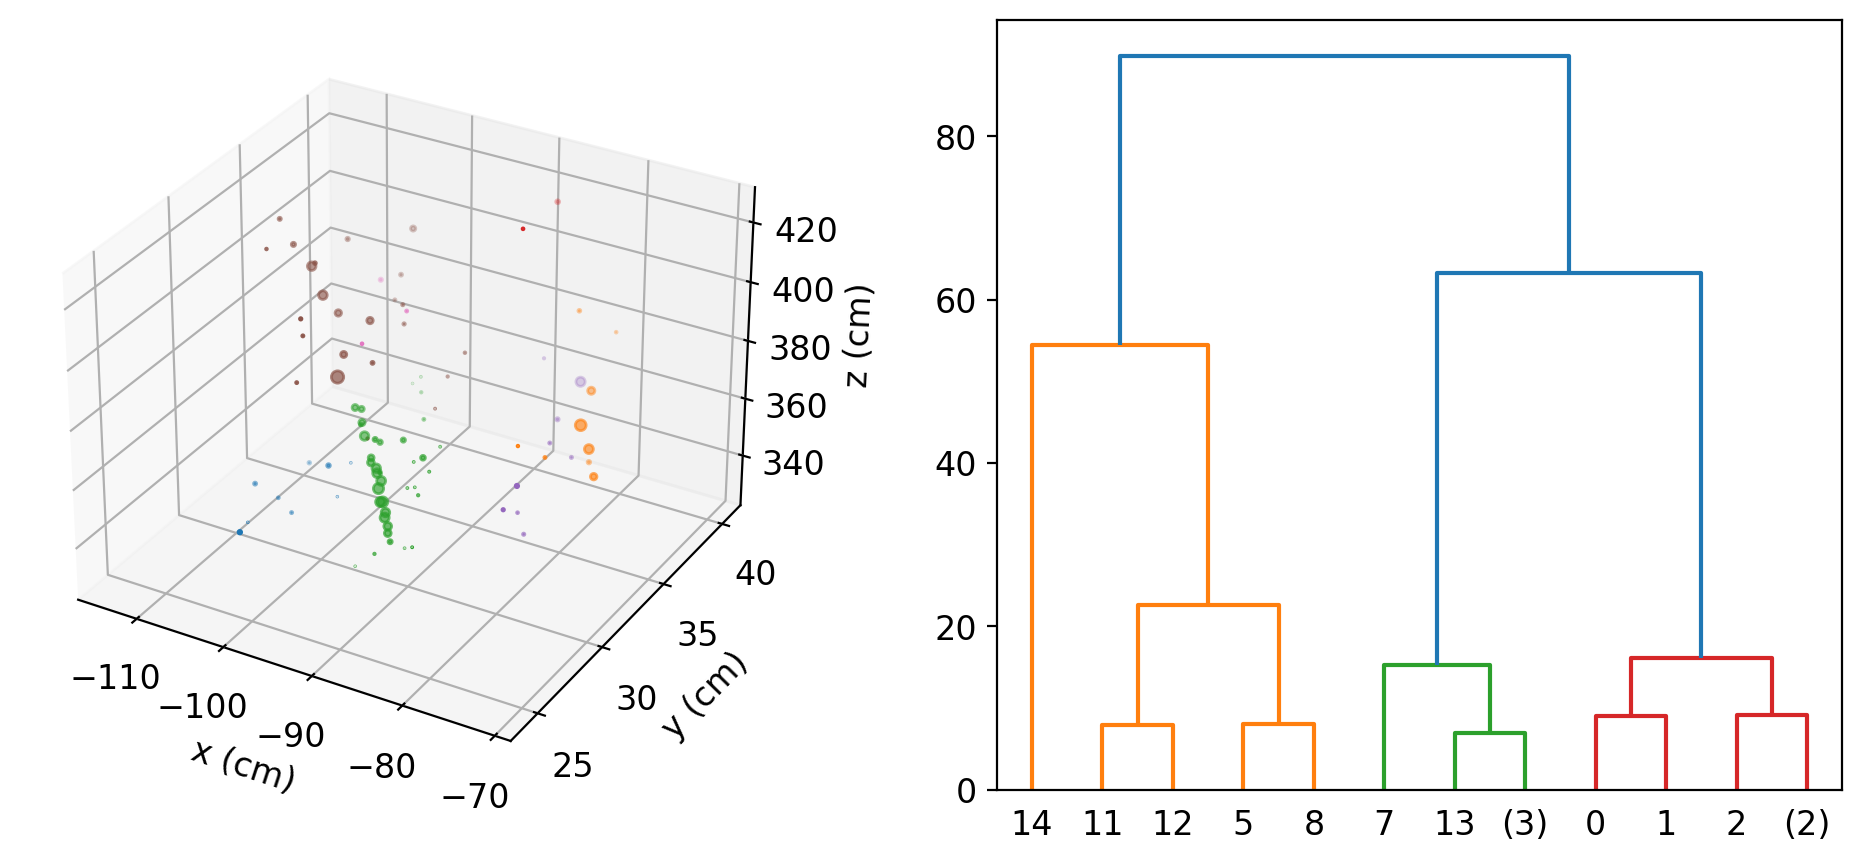

In [65]:
model = None
def agglomerative_bary(_data, _eid, distance_threshold=0):
    X_bary = get_bary_data(_data, _eid)
    global model
    model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=None)
    model.fit(X_bary)
    return model.labels_

labels = agglomerative_bary(trackster_data, eid, distance_threshold=12)

r_indexes = remap_arrays_by_label(t_indexes, labels)
r_x, r_y, r_z, r_e = clusters_by_indices(cluster_data, r_indexes, eid)

precision, recall, fscore = evaluate_remapped(nhits, t_indexes, st_indexes, t_energy, st_energy, t_multiplicity, st_multiplicity, labels)
print(f"In: {len(t_indexes)} Out: {max(labels) + 1} Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {fscore:.2f}")

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection="3d")
plot_tracksters(ax, r_x, r_y, r_z, r_e)

ax = fig.add_subplot(122)
plot_dendrogram(model, truncate_mode="level", p=3, ax=ax)

## Evaluations

In [10]:
results = []
nhits_ = cluster_data["cluster_number_of_hits"]
clusters_e_ = cluster_data["energy"]
t_multi_ = trackster_data["vertices_multiplicity"] 
st_multi_ = simtrackster_data["stsSC_vertices_multiplicity"]
t_indexes_ = trackster_data["vertices_indexes"]
st_indexes_ = simtrackster_data["stsSC_vertices_indexes"]

# get mean Precision, Recall and F-Score for the fill dataset
for eid in range(20):
    results.append((
        *evaluate(
            nhits_[eid],
            t_indexes_[eid],
            st_indexes_[eid],
            ak.Array([clusters_e_[eid][indices] for indices in t_indexes_[eid]]),
            ak.Array([clusters_e_[eid][indices] for indices in st_indexes_[eid]]),
            t_multi_[eid],
            st_multi_[eid]
        ),
        len(t_indexes_[eid])
    ))
in_mean = np.array(results).mean(axis=0)
in_mean.tolist()

[0.9928400280662093, 0.3007394905135533, 0.657833488850464, 28.1]

In [13]:
res = {}
for eps in range(2, 20, 2):
    baseline_results = baseline_evaluation(
        gmm_bary,
        cluster_data,
        trackster_data,
        simtrackster_data,
        max_events=20,
        eng_t=eps
    )
    out_mean = np.array(baseline_results).mean(axis=0)
    res[eps] = out_mean
    diff = out_mean - in_mean
    print(eps, diff.astype(float).tolist())

2 [-0.006109902237506071, 0.03920524192644398, 0.038611289988254804, -11.8]
4 [-0.01053886656824532, 0.08520456943098598, 0.07070243920455077, -19.1]
6 [-0.08130653031302426, 0.11128779653543575, 0.03819955782533713, -21.5]
8 [-0.11137476078820563, 0.15349524285834493, 0.04310207761621199, -23.450000000000003]
10 [-0.14653391070361232, 0.17401643061612931, 0.03963494447249438, -24.25]
12 [-0.16268932727453567, 0.18645219249791217, 0.03607704517022314, -24.700000000000003]
14 [-0.1719873766781298, 0.213803208371678, 0.046030387474101264, -24.85]
16 [-0.1608555113000405, 0.2307231794482003, 0.057640143312944425, -25.05]
18 [-0.16167002723859647, 0.2162094608291648, 0.05326580581242446, -25.1]


In [17]:
in_mean.tolist()

[0.8338938647178699, 0.09655080833227747, 0.6325458392812311, 96.75]

In [80]:
res[18]

array([0.95905288, 0.24808887, 0.85131781, 9.9       ])